# Assembly Tree Generation and Evaluation

#### Formulation
 - State Space $\mathcal{S}$ = {Every Possible Subassembly}
 - Action Space $\mathcal{A}_{\hat{s}}$ = { Every Connection that can currently be removed in state $\hat{s}$ }
 - $\mathcal{T}(s'|s,a)$ = Feasability Checks
 - $R(s,a)$ = Cost of removing a certain connection in line with the dynamics 
 - Graph Assumption: Order doesn't matter

#### Remarks
 - Note that the use of "H" and "G" are switched here compared to the paper

In [5]:
import sys, random, math, time, json
import numpy as np
import pprint as pp
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from itertools import count

%matplotlib inline

## Preliminary Code (Object Classes)

# HELPER FUNCTIONS

In [6]:
# Temporary Instantiations
Rewards = {}
seqConstraint = {}


def hierarchy_pos(G, root=None, width=20., vert_gap = 0.4, vert_loc = 0, xcenter = 0.5):  
    # From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):   
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos          
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


# Generating Subassemblies in a recursive manner
def recurGen(p, H, G):
    currCon = list(H.edges())
    if(len(currCon) > 0):
        i = G.number_of_nodes() + 1
        for c in currCon:
            Hnew = H.copy()
            Hnew.remove_edges_from([c])
            if(c in seqConstraint.keys() and seqConstraint[c] in Hnew.edges()):
                pass # This means a feasability constraint has been failed!
            else:
                idString = str(Hnew.edges())
                nextState = next((x for x, y in nx.get_node_attributes(G,'idS').items() if y == idString), None)
                if(nextState is not None):
                    Rew, Hnew = R(p, c, H)
                    G.add_edge(p, nextState, a=c, r=Rew)
                else:
                    G.add_node(i, idS=idString)
                    Rew, Hnew = R(p,c,H)
                    G.add_edge(p, i, a=c, r=Rew)
                    G = recurGen(i, Hnew, G)
            i = G.number_of_nodes() + 1
        return G
    else:
        return G


# Getting next set of possible states and actions
def nextGen(H):
    currCon = list(H.edges())
    G = nx.DiGraph()
    G.add_node(1, value=H, idS=str(H.edges()))

    if(len(currCon) > 0):
        for c in currCon:
            i = G.number_of_nodes() + 1
            if(c in seqConstraint.keys() and seqConstraint[c] in Hnew.edges()):
                pass # This means a feasability constraint has been failed!
            else:
                Hnew = H.copy()
                Hnew.remove_edges_from([c])
                G.add_node(i, idS=str(Hnew.edges()))
                Rew, Hnew = R(1,c,H)
                G.add_edge(1, i, a=c, r=Rew)

                # Hnew.remove_edges_from([c])
                # G.add_node(i, idS=str(Hnew.edges()))
                # G.add_edge(1, i, a=c, r=R(1,c))
        return G
    else:
        return None
    
    
# Checking Feasability
def T(sN, s, a):
    # Sequential Constraints are already handled via the tree generation!
    pass


# Cost structure which allows for an intermediary construction zone 
# between the supply vehicle and construction area
def Rcaz(s,a,H): # Reward Function Assuming there is a CAZ
    Rewards[(s,a)] = 0
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                if(Hnew.nodes[i[0]]["loc"] == "CL"): # Going from CL to SV
                    Hnew.nodes[i[0]]["loc"] = "SV"
                    Rewards[(s,a)] += -(0.0468 + 0.0499) #SV-CL + CL-SV
                else: # Going from CAZ to SV
                    Hnew.nodes[i[0]]["loc"] = "SV"
                    Rewards[(s,a)] += -(0.0403 + 0.0420) #SV-CAZ + CAZ-SV

            elif(len(i) == 2): # Have to fix last bit problem
                for p in i:
                    if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
                        Hnew.nodes[p]["loc"] = "CAZ"
                Rewards[(s,a)] += -(0.0307 + 0.0415) #SV-CL + CL-CAZ2

            elif(len(i) == 3): # Have to fix last problem
                for p in i:
                    if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
                        Hnew.nodes[p]["loc"] = "CAZ"
                Rewards[(s,a)] += -(0.0307 + 0.0475) #SV-CL + CL-CAZ3
    return Rewards[(s,a)], Hnew


# Reward Function Assuming there is NO CAZ (i.e, structures are constructed at the Supply Vehicle)
def RNOcaz(s,a,H):
    s = str(s)
    Rewards[(s,a)] = 0
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                Rewards[(s,a)] += -(0.0468 + 0.0499) #SV-CL + CL-SV

            elif(len(i) == 2):
                Rewards[(s,a)] += -(0.0749 + 0.0499) #SV-CL + CL-SV2

            elif(len(i) == 3):
                Rewards[(s,a)] += -(0.0869 + 0.0499) #SV-CL + CL-SV3
    return Rewards[(s,a)], Hnew



def Rcustom(s,a,H):
    s = str(s)
    Rewards[(s,a)] = -0.1
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                Rewards[(s,a)] += -1 #SV-CL + CL-SV

            elif(len(i) == 2):
                Rewards[(s,a)] += -1.5 #SV-CL + CL-SV2

            elif(len(i) == 3):
                Rewards[(s,a)] += -1.75 #SV-CL + CL-SV3
    return Rewards[(s,a)], Hnew


def Rsimple(s,a,H):
    lab = str(s)
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    edges = fullE.copy()
    if(edges.index(a) < H.number_of_edges()-1):
        Rewards[(lab,a)] = H.number_of_edges() - edges.index(a)
    else:
        Rewards[(lab,a)] = -1
    return Rewards[(lab,a)], Hnew



# Allows you to pick which reward function to use!
def R(s, a, H):
    lab = str(s)
    if((lab,a) not in Rewards.keys()):
        Rewards[(lab,a)], Hnew = RNOcaz(s,a,H)
    else:
        Hnew = H.copy()
        Hnew.remove_edges_from([a])
    return Rewards[(lab,a)], Hnew

## Scenario Initialization

##### "Hubble"

In [58]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "Hubble4"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(3,5)
H.add_edge(4,5)
H.add_edge(5,6)
H.add_edge(6,7)
H.add_edge(7,8)
H.add_edge(5,9)
H.add_edge(9,10)
H.add_edge(5,11)
H.add_edge(11,12)
H.add_edge(12,13)
H.add_edge(5,14)
H.add_edge(14,15)
H.add_edge(15,16)
H.add_edge(16,17)
H.add_edge(17,18)
H.add_edge(18,19)
H.add_edge(18,20)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

# seqConstraint = {(2,3): (1,2),
#                  (3,5): (2,3),
#                  (6,7): (7,8),
#                  (5,9): (9,10),
#                  (11,12): (12,13),
#                  (17,18): (18,19),
#                  (17,18): (18,20),
#                  (16,17): (17,18),
#                  (15,16): (16,17),
#                  (14,15): (15,16),
#                  (5,14): (14,15)}


print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Potential Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")

CONFIGURATION: 
	20 Parts,
	19 Connections in Assembly,
	4980737 Potential Subassemblies, 
	9437185 Potential Edges, 
	0 Sequential Constraints


##### "International Space Station"

In [33]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "ISS3"

#define topology
H = nx.Graph()
H.add_edges_from([(1,2), (2,3), (3,4), (4,5), (6,3), (7,1), (8,7), 
                  (9,7), (10,1), (11,10), (12,11), (13,11), (14,13), 
                  (15,13), (16,2), (17,16), (18,17), (19,17), (20,19), 
                  (21,19), (22,19), (23,22), (24,22), (25,16), (26,25), 
                  (27,25), (28,27), (29,27), (30,27), (31,30), (32,30)])
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")

CONFIGURATION: 
	32 Parts,
	31 Connections in Assembly,
	33285996545 Subassemblies, 
	64424509441 Potential Edges, 
	0 Sequential Constraints


##### "JWST Space Telescope"

CONFIGURATION: 
	180 Parts,
	256 Connections in Assembly,
	14821387422376473014217086081112052205218558037201992197050570753012880593911809 Potential Subassemblies, 
	29526982755515629833010601177215416502583846089738343830061683922017848058183681 Potential Edges, 
	0 Sequential Constraints


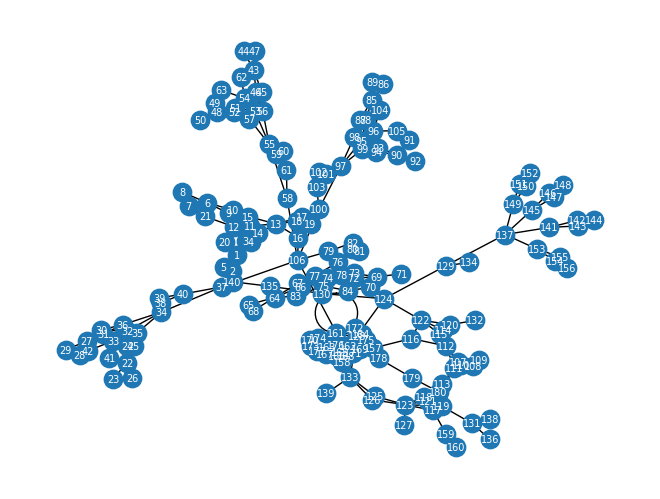

In [63]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "JWST7"

#define topology
H = nx.Graph()

H.add_edges_from([(1, 2), (1, 3), (1, 4), (1, 5), (1, 20), (3, 11), (3, 14), (4, 11), (4, 14), (6, 7), 
                  (6, 8), (6, 9), (6, 10), (7, 21), (9, 11), (9, 15), (10, 11), (10, 15), (11, 12), 
                  (11, 13), (12, 14), (12, 15), (12, 20), (12, 21), (13, 14), (13, 15), (13, 16), 
                  (13, 17), (13, 18), (16, 19), (16, 106), (17, 19), (18, 19), (22, 23), (22, 24), 
                  (22, 25), (22, 26), (22, 41), (24, 32), (24, 35), (25, 32), (25, 35), (27, 28), 
                  (27, 29), (27, 30), (27, 31), (28, 42), (30, 32), (30, 36), (31, 32), (31, 36), 
                  (32, 33), (32, 34), (33, 35), (33, 36), (33, 41), (33, 42), (34, 35), (34, 36), 
                  (34, 37), (34, 38), (34, 39), (37, 40), (37, 106), (38, 40), (39, 40), (43, 44), 
                  (43, 45), (43, 46), (43, 47), (43, 62), (45, 53), (45, 56), (46, 53), (46, 56), 
                  (48, 49), (48, 50), (48, 51), (48, 52), (49, 63), (51, 53), (51, 57), (52, 53), 
                  (52, 57), (53, 54), (53, 55), (54, 56), (54, 57), (54, 62), (54, 63), (55, 56), 
                  (55, 57), (55, 58), (55, 59), (55, 60), (58, 61), (58, 106), (59, 61), (60, 61), 
                  (64, 65), (64, 66), (64, 67), (64, 68), (64, 83), (66, 74), (66, 77), (67, 74), 
                  (67, 77), (69, 70), (69, 71), (69, 72), (69, 73), (70, 84), (72, 74), (72, 78), 
                  (73, 74), (73, 78), (74, 75), (74, 76), (75, 77), (75, 78), (75, 83), (75, 84), 
                  (76, 77), (76, 78), (76, 79), (76, 80), (76, 81), (79, 82), (79, 106), (80, 82), 
                  (81, 82), (85, 86), (85, 87), (85, 88), (85, 89), (85, 104), (87, 95), (87, 98), 
                  (88, 95), (88, 98), (90, 91), (90, 92), (90, 93), (90, 94), (91, 105), (93, 95), 
                  (93, 99), (94, 95), (94, 99), (95, 96), (95, 97), (96, 98), (96, 99), (96, 104), 
                  (96, 105), (97, 98), (97, 99), (97, 100), (97, 101), (97, 102), (100, 103), 
                  (100, 106), (101, 103), (102, 103), (106, 161), (107, 108), (107, 109), (107, 112), 
                  (107, 113), (108, 110), (108, 111), (109, 110), (110, 112), (110, 113), (111, 112), 
                  (111, 113), (112, 114), (112, 115), (112, 116), (112, 120), (113, 117), (113, 118), 
                  (113, 119), (113, 121), (114, 122), (115, 122), (116, 122), (116, 157), (120, 122), 
                  (120, 132), (117, 123), (117, 159), (118, 123), (119, 123), (119, 131), (121, 123), 
                  (122, 124), (123, 125), (123, 126), (123, 127), (124, 128), (124, 129), (124, 130), 
                  (125, 133), (126, 133), (128, 133), (129, 134), (129, 137), (130, 135), (131, 136), 
                  (131, 138), (133, 139), (135, 140), (137, 141), (137, 145), (137, 149), (137, 153), 
                  (141, 142), (141, 143), (142, 144), (143, 144), (145, 146), (145, 147), (146, 148), 
                  (147, 148), (149, 150), (149, 151), (150, 152), (151, 152), (153, 154), (153, 155), 
                  (154, 156), (155, 156), (157, 158), (159, 160), (161, 161), (161, 162), (161, 163), 
                  (161, 164), (161, 165), (161, 166), (161, 167), (161, 168), (161, 169), (161, 170), 
                  (161, 171), (161, 172), (161, 173), (161, 174), (161, 175), (161, 176), (161, 177), 
                  (161, 178), (178, 179), (179, 180)])

nx.set_node_attributes(H, "CL", "loc")
numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Potential Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF", node_size=175, font_size=7)
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)
plt.show()

##### "Lattice"

CONFIGURATION: 
	9 Parts,
	12 Connections in Assembly,
	24577 Subassemblies, 
	45057 Potential Edges, 
	4 Sequential Constraints


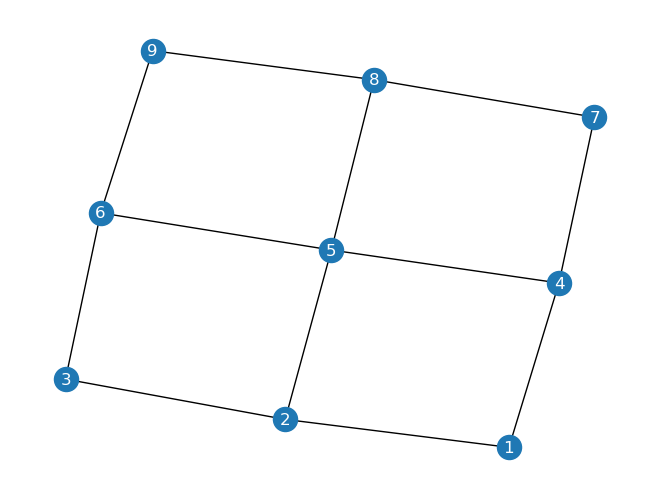

In [81]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "Lattice"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(1,4)
H.add_edge(5,4)
H.add_edge(5,2)
H.add_edge(6,5)
H.add_edge(6,3)
H.add_edge(7,4)
H.add_edge(8,7)
H.add_edge(8,5)
H.add_edge(9,8)
H.add_edge(9,6)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {(2,5): (1,4),
                 (2,5): (3,6),
                 (4,5): (1,2),
                 (4,5): (7,8),
                 (5,8): (4,7),
                 (5,8): (6,9),
                 (5,6): (2,3),
                 (5,6): (8,9)}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")

##### "2 x 3"

CONFIGURATION: 
	6 Parts,
	7 Connections in Assembly,
	449 Subassemblies, 
	769 Potential Edges, 
	4 Sequential Constraints


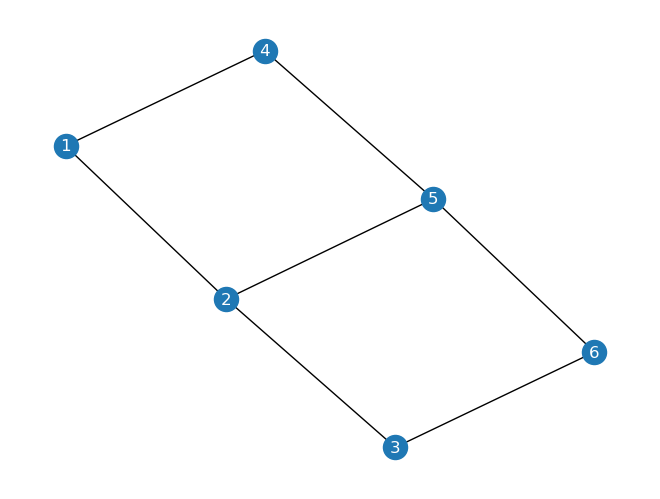

In [128]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "2x3"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(1,4)
H.add_edge(4,5)
H.add_edge(5,6)
H.add_edge(2,5)
H.add_edge(3,6)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {(2,5): (1,4),
                 (2,5): (3,6),
                 (4,5): (1,2),
                 (4,5): (7,8),
                 (5,8): (4,7),
                 (5,8): (6,9),
                 (5,6): (2,3),
                 (5,6): (8,9)}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")

##### "3-Piece"

CONFIGURATION: 
	3 Parts,
	3 Connections in Assembly,
	13 Subassemblies, 
	17 Potential Edges, 
	0 Sequential Constraints


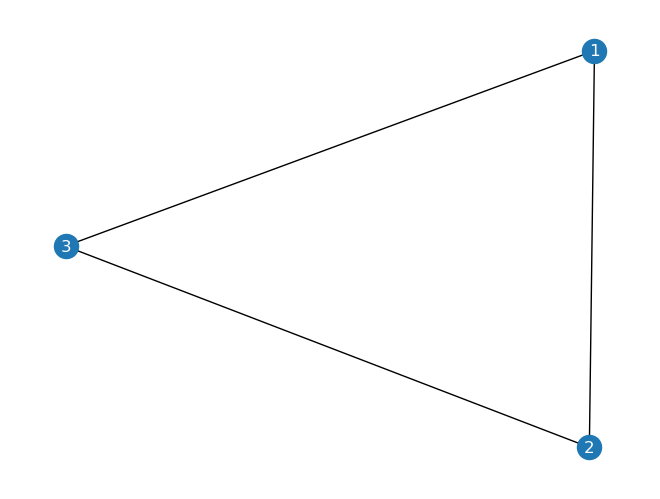

In [129]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "3Piece"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(3,1)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")

##### "4-Brick"

CONFIGURATION: 
	4 Parts,
	3 Connections in Assembly,
	13 Subassemblies, 
	17 Potential Edges, 
	0 Sequential Constraints


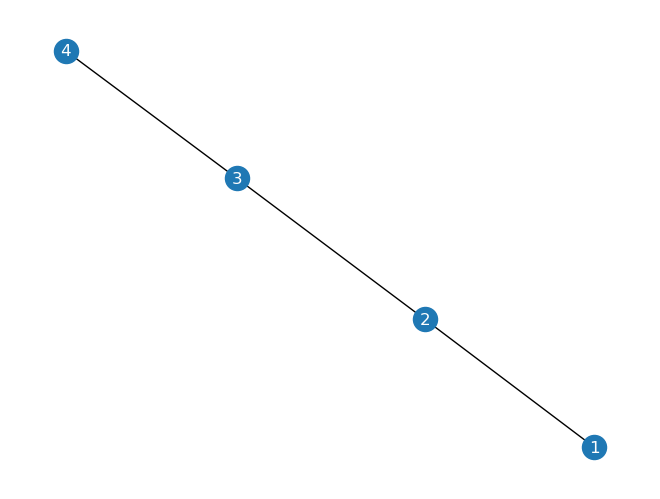

In [130]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "4Brick"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(3,4)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")

##### "N Long Chain"

CONFIGURATION: 
	50 Parts,
	49 Connections in Assembly,
	13792273858822145 Subassemblies, 
	27021597764222977 Potential Edges, 
	17 Sequential Constraints


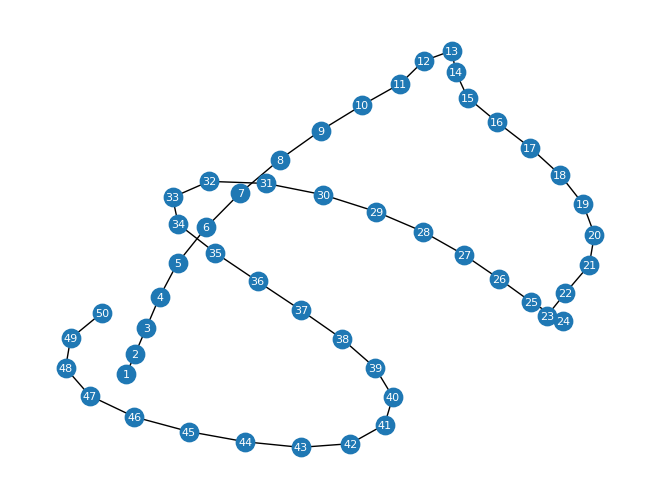

In [133]:
# Initialize the inputs (will later read in from file [JSON])
N = 50 # Number of Parts

Scenario = str(N)+"LongChain"

#define topology
H = nx.Graph()
for i in range(1,N):
    H.add_edge(i,i+1)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
e = list(H.edges())
seqConstraint = {e[i] for i in range(0,H.number_of_edges(),3)}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF", node_size=175, font_size=8)

##### "Random Tree"

CONFIGURATION: 
	100 Parts,
	99 Connections in Assembly,
	31374352355648677687043404333057 Subassemblies, 
	62114879411183240673338457063425 Potential Edges, 
	0 Sequential Constraints


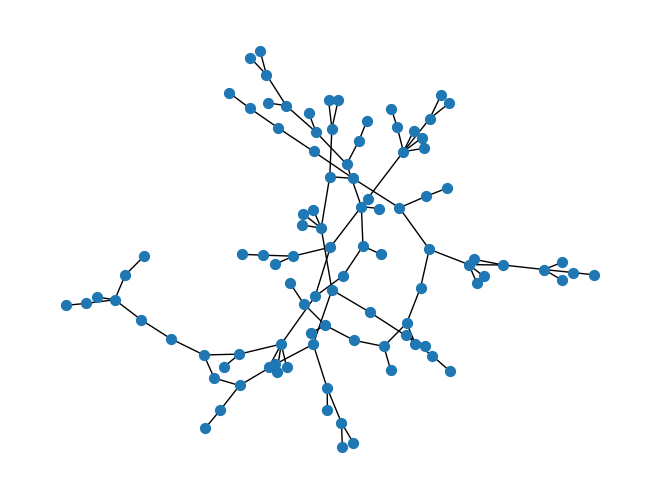

In [12]:
# Initialize the inputs (will later read in from file [JSON])
N = 100 # Number of Parts

Scenario = str(N)+"RandomTree"

#define topology
H = nx.random_tree(n=N)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=False, node_size=50)

## DQN

JWST7 cuda
0
Complete


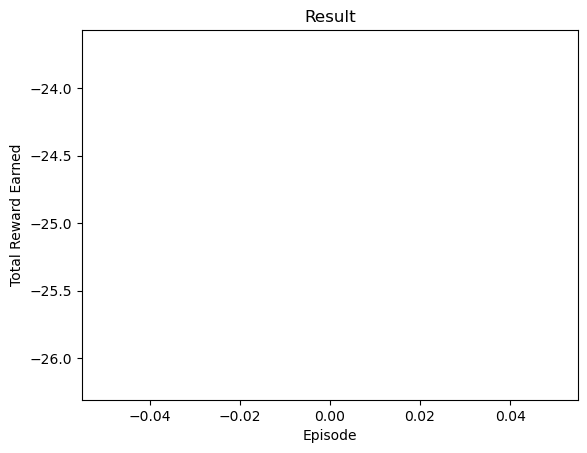

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(Scenario, device)

# ~~~ MAIN ~~~
BATCH_SIZE = H.number_of_edges()*3            # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 1                   # GAMMA is the discount factor as mentioned in the previous section
EPS_START = 0.85            # EPS_START is the starting value of epsilon
EPS_END = 0.05              # EPS_END is the final value of epsilon
EPS_DECAY = 1000            # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.01                 # TAU is the update rate of the target network
LR = 1e-3                   # LR is the learning rate of the AdamW optimizer


## DEFAULTS
# BATCH_SIZE = 128
# GAMMA = 0.99
# EPS_START = 0.9
# EPS_END = 0.05
# EPS_DECAY = 1000
# TAU = 0.005
# LR = 1e-4


HQ = H.copy() # Copy of the fully connected structure to use for the Q-Learning segment

fullE = list(HQ.edges())
state = [1 if e in HQ.edges() else 0 for e in fullE]
n_actions = HQ.number_of_edges()

n_observations = HQ.number_of_edges()
policy_net = net.DQN(n_observations, n_actions).to(device)
target_net = net.DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = net.ReplayMemory(100000)

if(True):
    episode_durations = []


def to_graph(state):
    Hs = nx.Graph()
    for i in range(len(state)):
        if(state[i] == 1):
            Hs.add_edge(fullE[i][0], fullE[i][1])
    nx.set_node_attributes(Hs, "CL", "loc")
    return Hs



steps_done = 0
def select_action(state, test=False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold or test:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            qvals = policy_net(state)
            choice = qvals.max(0)[1].view(1, 1)
            if(state[choice] == 1):
                return torch.tensor(fullE[choice], device=device, dtype=torch.long)
            else:
                for c in range(len(qvals)):
                    qvals[choice] = np.NINF
                    choice = qvals.max(0)[1].view(1, 1)
                    if(state[choice] == 1):
                        return torch.tensor(fullE[choice], device=device, dtype=torch.long)
    else:
        actionSpace = [fullE[i] for i in range(len(state)) if state[i] == 1]
        return torch.tensor(random.choice(actionSpace), device=device, dtype=torch.long)
    

fig = plt.figure(1)
def plot_durations(show_result=False):
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward Earned')
    plt.plot(durations_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated



def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = net.Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.stack(batch.state)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(0, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


if torch.cuda.is_available():
    num_episodes = 1
else:
    num_episodes = 1000

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = np.ones(len(fullE))
    if(i_episode % 200 == 0):
        print(i_episode)
        # Maybe randomize the initial state?

    Hi = HQ.copy() # Copy of H for this episode
    # state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)
    totR = 0
    for t in count():
        action = select_action(state)
        reward, Hi = R(state, tuple(action.tolist()), to_graph(state))
        totR += reward
        observation = [1 if e in Hi.edges() else 0 for e in fullE]
        terminated = (Hi.number_of_edges() == 0)
        reward = torch.tensor([1+reward], device=device)
        done = terminated
        #print(state, action, reward)

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(totR)
            break

print('Complete')
plot_durations(show_result=True)
fig.savefig("RESULTS/DQN/"+Scenario+" Training.eps", format="eps", dpi=1200)

plt.ioff()
plt.show()

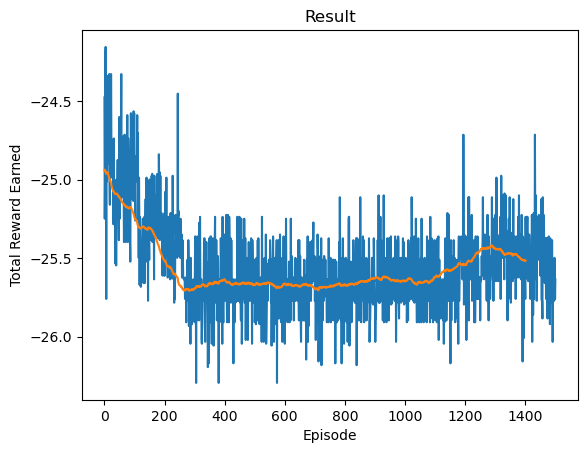

<Figure size 640x480 with 0 Axes>

In [106]:
plot_durations(show_result=True)
plt.ioff()
plt.savefig("RESULTS/DQN/"+Scenario+" Training.eps", format="eps", dpi=1200)
plt.show()

# Baselines

-22.311


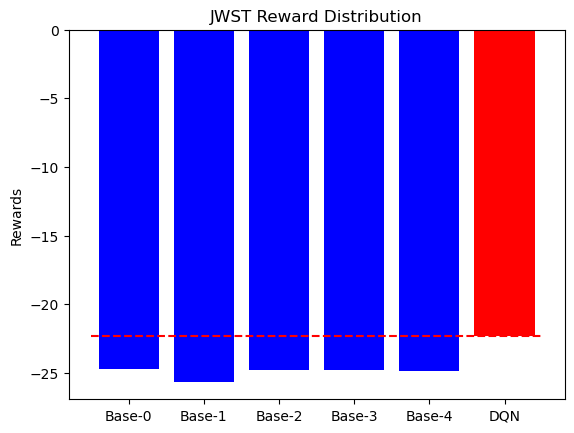

In [65]:
fullE = list(HQ.edges())
state = torch.tensor([1 if e in HQ.edges() else 0 for e in fullE], dtype=torch.float32, device=device)
n_actions = HQ.number_of_edges()
numBaselines = 5

Hi = HQ.copy()

Qr = 0
Qstrat = []
baseR = [0]*numBaselines #np.zeros(numBaselines) # [0]*numBaselines
baseStrat = [[] for i in range(numBaselines)]
baseState = [[1]*len(state) for i in range(numBaselines)] #np.zeros([len(state), numBaselines])
for t in range(n_actions):
    qvals = target_net(state)
    choice = qvals.max(0)[1].view(1, 1)
    if(state[choice] == 1):
        Qstrat.append(fullE[choice])
        reward, Hi = R(state, fullE[choice], to_graph(state))
        Qr += reward
        state[choice] = 0
    else:
        for c in range(len(qvals)):
            qvals[choice] = np.NINF
            choice = qvals.max(0)[1].view(1, 1)
            if(state[choice] == 1):
                Qstrat.append(fullE[choice])
                reward, Hi = R(state, fullE[choice], to_graph(state))
                Qr += reward
                state[choice] = 0
                break
    for b in range(numBaselines):
        potentialChoices = [i for i in range(len(baseState[b])) if baseState[b][i] == 1]
        choice = random.choice(potentialChoices)
        baseStrat[b].append(fullE[choice])
        reward, Hi = R(baseState[b], fullE[choice], to_graph(baseState[b]))
        baseR[b] += reward
        baseState[b][choice] = 0
        

# Hardcoding the Qr's for plots for the paper 
# (these results were established earlier and I don't want to retrain)
# Qr = -1.115  #Hubble
# Qr = -2.81   #ISS
# Qr = -22.311 #JWST

# pp.pprint(Qstrat)
print(Qr)

# print(np.array(baseStrat))
# print(baseR)

data = {}
data["DQN"] = {"Strat": Qstrat, "R": Qr, 
               "Hyperparameters": {"Batch Size": BATCH_SIZE, 
                                   "Gamma": GAMMA,
                                   "EpsilonStart": EPS_START,
                                   "EpsilonEnd": EPS_END,
                                   "EpsilonDecay": EPS_DECAY,
                                   "Tau": TAU,
                                   "LearningRate": LR,
                                   "NumEpisodes": num_episodes}}
for b in range(numBaselines):
    data["Base-" + str(b)] = {"Strat": baseStrat[b], "R": baseR[b]}

json.dump(data, open("RESULTS/DQN/"+Scenario+".json", "w"))

plt.bar(["Base-"+str(b) for b in range(len(baseR))], baseR, color="b", label=Qr)
plt.bar(["DQN"], Qr, color="r", label=Qr)
plt.plot([-0.5,5.5], [Qr,Qr], ls='--', c='r')
plt.ylabel("Rewards")
if(Scenario[-1].isdigit()):
    plt.title(Scenario[:-1]+" Reward Distribution")
else:
    plt.title(Scenario+" Reward Distribution")
plt.savefig("RESULTS/DQN/"+Scenario+" Reward Distribution.eps", format="eps", dpi=1200)
plt.show()


In [62]:
print(baseR)
print(max(baseR))

[-1.6502, -1.7629999999999995, -1.8998, -1.5134000000000003, -1.6381999999999999, -2.0365999999999995, -2.0366, -1.6382000000000003, -2.0365999999999995, -1.6502, -1.8998, -1.8878000000000004, -1.763, -1.8998000000000004, -2.0246000000000004, -1.6381999999999999, -1.6262000000000003, -2.0366, -2.0246, -1.5253999999999999, -2.0366, -1.8998000000000004, -1.7870000000000004, -1.763, -2.0485999999999995, -1.7630000000000003, -1.8998000000000004, -1.8998, -1.7630000000000003, -1.775, -1.751, -2.0366, -1.7750000000000004, -2.0365999999999995, -1.8998, -1.8878, -1.6381999999999999, -2.0366, -1.6381999999999999, -1.7630000000000003, -1.7750000000000004, -2.1734, -1.6381999999999999, -1.775, -1.6502, -1.9118, -1.751, -1.7510000000000003, -2.0366, -1.8997999999999995, -1.8878, -1.8998000000000004, -1.763, -1.6502, -2.0246, -1.6381999999999999, -2.1734, -1.9118, -2.1614000000000004, -2.0246000000000004, -1.775, -1.6381999999999994, -2.0365999999999995, -1.8878, -1.8998000000000004, -1.763, -2.161

In [ ]:
# Smart Search
fullE = list(HQ.edges())
state = torch.tensor([1 if e in HQ.edges() else 0 for e in fullE], dtype=torch.float32, device=device)
n_actions = HQ.number_of_edges()
numBaselines = 20000

baseR = [0]*numBaselines
baseStrat = [[] for i in range(numBaselines)]
baseState = [[1]*len(state) for i in range(numBaselines)]
for t in range(n_actions):
    for b in range(numBaselines):
        potentialChoices = [i for i in range(len(baseState[b])) if baseState[b][i] == 1]
        choice = random.choice(potentialChoices)
        reward, Hi = R(baseState[b], fullE[choice], to_graph(baseState[b]))
        if(b > 0 and reward > baseR[b-1]):
            choice = random.choice(potentialChoices)
            reward, Hi = R(baseState[b], fullE[choice], to_graph(baseState[b]))
        baseStrat[b].append(fullE[choice])
        baseR[b] += reward
        baseState[b][choice] = 0

### Running the Assembly Generation

In [50]:
# Simple initial initialization (will later read in from file [JSON])
Rewards = {}
fullE = list(H.edges())

# Generate the assembly tree
start = time.time()
G = nx.DiGraph()
G.add_node(1, idS=str(H.edges()))
G = recurGen(1, H, G)
end = time.time()
print("Assembly Generation Time: %f" % (end-start))

print(fullE)
print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

Assembly Generation Time: 148.900588
[(1, 2), (2, 3), (3, 5), (5, 4), (5, 6), (5, 9), (5, 11), (5, 14), (6, 7), (7, 8), (9, 10), (11, 12), (12, 13), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (18, 20)]
DONE: 12096 Nodes and 67824 Edges


### Value Iteration

In [52]:
def ValueIteration(G, H, maxIter, eps):
    S = range(1, G.number_of_nodes()+1)
    A = list(H.edges())

    V = {s: 0.0 for s in S}
    Vnew = V.copy()
    π = {s: (0, (0,0)) for s in S}
    delta = max([abs(V[s] - Vnew[s]) for s in S])

    c = 0
    while(c <= maxIter):
        delta = 0
        for s in S:
            nextStates = G[s]
            for sN in nextStates.items():
                newV = sN[1]['r'] + V[sN[0]]
                if(newV > Vnew[s] or Vnew[s] == 0.0):
                    Vnew[s] = newV
                    π[s] = (sN[0], sN[1]['a'])
        delta = max([abs(V[s] - Vnew[s]) for s in S])
        if(delta < eps):
            print("Converged!")
            return Vnew, π
        V = Vnew.copy()
        c += 1
    print("Done")

maxIter = 100000
eps = 1e-6
start = time.time()
V, π = ValueIteration(G, H, maxIter, eps)
end = time.time()
print("Value Iteration Time: %f" % (end-start))

Converged!
Value Iteration Time: 0.534878


### Tabular Q-Learning

In [ ]:
maxIter = 10000
c = 0
G = nx.DiGraph()
Q = {}
ϵ = 0.3
gamma = 1
policy = {}

while c < maxIter:
    # Get random state
    currPos = H.copy()
    numCuts = random.randint(0, currPos.number_of_edges()-1)
    edges = list(currPos.edges())
    for i in range(numCuts):
        rc = edges.pop(random.randint(0, len(edges)-1))
        currPos.remove_edges_from([rc])
    # print(currPos)
    #nx.draw(currPos, with_labels=True, font_color="#FFFFFF")
    
    # Get random action
    nextPos = currPos.copy()
    edgeList = list(currPos.edges())
    if(len(edgeList) > 0):
        A = edgeList[random.randint(0, len(edgeList)-1)]
        nextPos.remove_edges_from([A])
    else:
        continue
    
    # Find "sN"s
    G.add_node(1, idS=str(nextPos.edges()))
    nearest = nextGen(nextPos)
    # print(nearest)
    if(nearest is None):
        continue
    
    # Pick best and go
    actions = nx.get_edge_attributes(nearest,'r')
    maxA = random.choice([k for k in actions.keys() if actions[k] == max(actions.values())])
    s = currPos.copy()
    sN = currPos.remove_edges_from([maxA])
    
    label = str(np.array(nx.adjacency_matrix(s)))
    if((label,A) in Q.keys() and sN is not None):
        Qp = [0]
        for e in list(sN.edges()):
            if((sN,e) in Q.keys()):
                Qp.append(Q[sN,e])
        Q[(label,maxA)] = Q[(label,maxA)] + ϵ*(actions[maxA] + gamma*max(Qp) - Q[(label,maxA)])
    else:
        Q[(label,maxA)] = actions[maxA]
        
    c += 1

pp.pprint(Q)
print(len(Q.keys()))

NameError: name 'nx' is not defined

## Graphing Suite

In [56]:
# try:
#     pos = hierarchy_pos(G,1)
# except:
#     pos = nx.planar_layout(G)
actions = nx.get_edge_attributes(G,'r')
#nx.draw(G, pos, with_labels=True, font_color="#FFFFFF")
#nx.draw_networkx_edge_labels(G, pos, edge_labels = actions)

try:
    Rew = 0
    S = range(1, G.number_of_nodes()+1)
    path = [1, π[1][0]]
    strat = [π[1][1]]
    path_edges = [(1, path[-1])]
    while(True):
        currState = path[-1]
        nextState = π[currState][0]
        if(nextState in S):
            Rew += actions[(currState, nextState)]
            path.append(nextState)
            strat.append(π[currState][1])
            path_edges.append((currState, nextState))
        else:
            break
    print(path_edges)
    print(strat)
    #nx.draw_networkx_nodes(G,pos,nodelist=path,node_color='r')
    #nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='r',width=1)
except:
    print("No Policy Found")


# strat = fullE.copy()
# strat.reverse()
# Re = 0
# s = np.ones(len(fullE))
# for t in range(len(s)):
#     Re += R(s, strat[t], to_graph(s))[0]
#     s[fullE.index(strat[t])] = 0

print("Reward: "+str(Rew))
print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 1140), (1140, 1141), (1141, 386), (386, 387), (387, 388), (388, 389), (389, 404), (404, 405), (405, 406), (406, 407), (407, 408), (408, 409), (409, 32), (32, 33), (33, 20)]
[(1, 2), (2, 3), (3, 5), (5, 4), (7, 8), (6, 7), (5, 6), (9, 10), (5, 9), (12, 13), (18, 19), (18, 20), (17, 18), (16, 17), (15, 16), (14, 15), (5, 11), (5, 14), (11, 12)]
Reward: -0.8935000000000002
DONE: 12096 Nodes and 67824 Edges


In [ ]:
nx.draw(H, with_labels=True, font_color="#FFFFFF")

In [ ]:
V = G.copy()
try:
    plotVis(V)
except:
    try:
        plotVis(V)
    except:
        print("Nope!")